# Domain Decomposition and Grid Generation
#### (and maybe other things?)

### Building everything you might need for stencil generation

This notebook steps through domain decomposition into tiles, projection of points onto the grid, and building everything else needed for stencil generation later on (e.g., standalone tracer advection).

In addition, it also shows how to retrieve some data (lat, lon, dx, dy) and plot them on a sphere.

Inside `functions.py`, some of these steps are consolidated into functions:
- configuration steps: `configure_domain()`,
- retrieving latitude and longitude: `get_lon_lat_edges()`,
- plotting grid edges on projection: `plot_grid()`,
- plotting a field on projection: `plot_projection_field()`.

In [1]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


Setting up configuration parameters for grid generation: layout and number of grid points per tile.

In [2]:
%%capture
nx = 20
ny = 20
nz = 79
""" (int): number of points per tile in each direction """

nhalo = 3
""" (int): number of halo points in x- and y- directions """

layout = (1, 1)
""" (int, int): how many parts each tile is split into? """

backend = "numpy"
""" (str): 
    - other options? Untested. """

Initializing Message Passing Interface (MPI) communicator and confirming the number of tiles (mpi_size).

In [21]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

## Domain decomposition

Add some text here describing what this portion does. 

Maybe:
At this point, each individual tile doesn't really have any idea that it's on a cubed-sphere.

- `TilePartitioner`: what does this do?
- `CubedSpherePartitioner`: what does this do?
- `CubedSphereCommunicator`: performs communications on the cubed sphere.
- `SubtileGridSizer`: what does this do?

In [23]:
%%capture
from pace.util import (
    CubedSphereCommunicator, 
    CubedSpherePartitioner, 
    QuantityFactory, 
    SubtileGridSizer, 
    TilePartitioner
)

partitioner = CubedSpherePartitioner(TilePartitioner(layout))

communicator = CubedSphereCommunicator(mpi_comm, partitioner)

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=nx,
    ny_tile=ny,
    nz=nz,
    n_halo=nhalo,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(
    sizer=sizer, 
    backend=backend
)

## Grid generation

Add some text here describing what this portion does. 

Maybe: 
These construct data to project everything on the cubed-sphere?

- `MetricTerms`:
- `DampingCoefficients`: (might not be needed?? but get used in initializing fvtp2d)
- `GridData`: includes information like lat, lon, dx, dy, area, ...

In [24]:
%%capture
from pace.util.grid import (
    DampingCoefficients, 
    GridData, 
    MetricTerms
)

metric_terms = MetricTerms(
    quantity_factory=quantity_factory, 
    communicator=communicator
)

damping_coefficients = DampingCoefficients.new_from_metric_terms(metric_terms)

grid_data = GridData.new_from_metric_terms(metric_terms)    

## Components for Building Stencils

Add some text here describing what this portion does. 



- `DaceConfig`:
- `CompilationConfig`: 
- `StencilConfig`:
- `GridIndexing`:
- `StencilFactory`:

The lines that come after grid indexing basically hack the code so it only contains one vertical level.

In [7]:
from pace.dsl.dace.dace_config import (
    DaceConfig, 
    DaCeOrchestration
)
from pace.dsl.stencil import (
    GridIndexing, 
    StencilConfig, 
    StencilFactory
)
from pace.dsl.stencil_config import (
    CompilationConfig, 
    RunMode
)


dace_config = DaceConfig(
    communicator=communicator, 
    backend=backend, 
    orchestration=DaCeOrchestration.Python
) 

compilation_config = CompilationConfig(
    backend=backend, 
    rebuild=True, 
    validate_args=True, 
    format_source=False, 
    device_sync=False, 
    run_mode=RunMode.BuildAndRun, 
    use_minimal_caching=False, 
    communicator=communicator,
)

stencil_config = StencilConfig(
    compare_to_numpy=False,
    compilation_config=compilation_config,
    dace_config = dace_config
)

grid_indexing = GridIndexing.from_sizer_and_communicator(
        sizer=sizer, 
        cube=communicator
    )

# set the domain so there is only one level in the vertical -- forced
domain = grid_indexing.domain
domain_new = list(domain)
domain_new[2] = 1
domain_new = tuple(domain_new)

grid_indexing.domain = domain_new

stencil_factory = StencilFactory(
    config=stencil_config, 
    grid_indexing=grid_indexing
    )

## Retrieving Coordinates

Retrieving longitude and latitude of grid edges from input configuration. 

This is consolidated in `get_lon_lat_edges()` in `functions.py`.

In [8]:
import numpy as np
from pace.util import Quantity

lon = Quantity(
    grid_data.lon.data * 180 / np.pi,
    ("x_interface", "y_interface"),
    "degrees",
    (nhalo, nhalo),
    (nx+1, ny+1),
    backend,
)

lat = Quantity(
    grid_data.lat.data * 180 / np.pi,
    ("x_interface", "y_interface"),
    "degrees",
    (3, 3),
    (nx+1, ny+1),
    backend,
)

lon_gather = communicator.gather(lon)
lat_gather = communicator.gather(lat)


## Plotting the grid

Uses Cartopy and fv3viz to plot the grid edges defined in lon and lat quantities.

Both the coordinate retrieval and plotting are consolidated in `plot_grid()` inside `functions.py`.

[output:0]

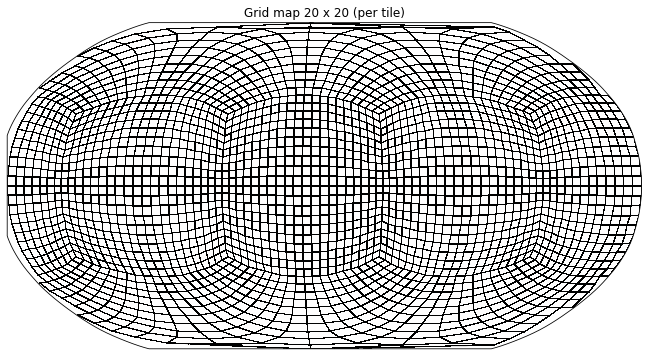

In [9]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if mpi_rank == 0:
    field = np.zeros(lon_gather.data.shape)[:, :-1, :-1]

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())

    pcolormesh_cube(lat_gather.data, lon_gather.data, field, 
        cmap="bwr", vmin=-1, vmax=1, edgecolor="k", linewidth=0.1,
    )

    ax.set_title('Grid map %s x %s (per tile)' % (nx, ny))

    plt.show()

## Retrieving and Plotting More Data

You can use quantities to retrieve any data that is stored inside `grid_data` or any of the other constructed variables, gather it on the root engine and then plot it.

In this case, the area of each grid cell is plotted.

The coordinate retrieval and plotting is done in `plot_projection_field()` inside `functions.py`.

[output:0]

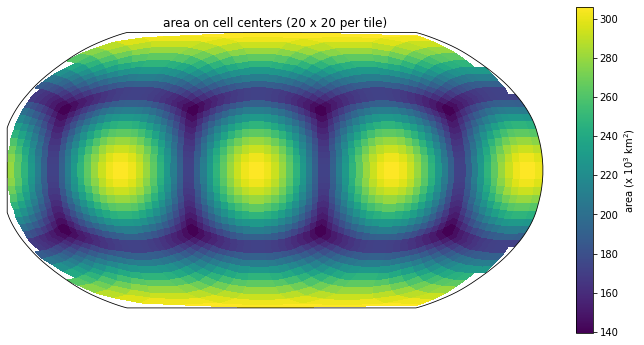

In [10]:
area = Quantity(
    grid_data.area.data,
    ("x", "y"),
    "m",
    (nhalo, nhalo),
    (nx, ny),
    backend,
)

area_gather = communicator.gather(area)

if mpi_rank == 0:
    
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())

    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, area_gather.data/(1e6)/1e3)

    plt.colorbar(f1, label='area (x $10^3$ km$^2$)')

    ax.set_title('area on cell centers (%s x %s per tile)' % (nx, ny))

    plt.show()

### The functions inside functions.py

expect data in a specific order, which you can reproduce by following the below syntax.

In [22]:
import functions as func

namelistDict = func.store_namelist_variables(locals())
metadata, rank = func.define_metadata(namelistDict, mpi_comm)